# <div style="text-align: center;"> Advanced AI 4 Assignment</div>

<div style="text-align: right"> By me: Atvars Apinis

## <div style="text-align: center;"> Part 1: Data Collection</div>
---

### Question 1: What is wrong with the coding practice in this example?
```py
def show(data: pd.DataFrame):
    df = data.copy()
    df = df.style.format(precision=3)
    df = df.background_gradient(cmap='Reds', axis=0)
    display(df)

def highlight_half(data: pd.DataFrame, axis=1, precision=3):
    
    s = data.shape[1] if axis else data.shape[0]
    data_style = data.style.format(precision=precision)

    def apply_style(val):
        style1 = 'background-color: red; color: white'
        style2 = 'background-color: blue; color: white'
        return [style1 if x < s//2 else style2 for x in range(s)]

    display(data_style.apply(apply_style, axis=axis))
```

- It's a bad practice to have a parameter for a function that doesn't use any parameters (`apply_style`).
- Another bad practice is to define a function within a function.
- The third bad practice is to hard code the colors for the function styling. 

## Question 2: Use Google stock data instead of Tesla. 

You can use the data given in the demo, but in the assignment notebook there is also another way to download this data. Describe how, use the data from 01/01/2017 up until 31/12/2024 and use the same columns as for the Tesla data. Check the meaning of these columns.

#### Answer:

For getting the financial data, I will use the library `yfinance`. This library grabs financial data from the Yahoo finance API. 

In [1]:
# Data Imports
import yfinance as yf
import pandas as pd 
import numpy as np 
import random

from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import BDay

# Visualization Imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import scipy.stats as stats

# Setting seed
SEED = 25_05_2004 # My Birthday
random.seed(SEED)
np.random.seed(SEED)
# tf.random.set_seed(SEED)

# Visualization Configurations
pio.templates.default = "plotly_dark"
%config InlineBackend.figure_format = 'retina'

In [50]:
# Target stock & columns for modeling
SYMBOL = "GOOGL"
columns = ['open', 'high', 'low', 'close', 'volume']

# Getting Tesla (TSLA) stock data
ticker = yf.Ticker(SYMBOL)

# End stock dates
end_date = "2024-12-31"

# Pulling stock data 
df = ticker.history(start="2017-01-01", end=end_date)
df.columns = df.columns.str.lower()

# Showing data
df.tail()


,open,high,low,close,volume,dividends,stock splits
Date,,,,,,,
2024-12-23 00:00:00-05:00,192.398415,194.875573,189.931255,194.406113,25675000,0.0,0.0
2024-12-24 00:00:00-05:00,194.615856,195.884399,193.557078,195.884399,10403300,0.0,0.0
2024-12-26 00:00:00-05:00,194.925505,196.523671,194.156402,195.375000,12046600,0.0,0.0
2024-12-27 00:00:00-05:00,194.725737,195.095322,190.430680,192.538254,18891400,0.0,0.0
2024-12-30 00:00:00-05:00,189.581658,192.328495,188.902433,191.020004,14264700,0.0,0.0


In [51]:
print(df.shape)

(2011, 7)


## <div style="text-align: center;"> Part 2: Data Visualization</div>
---

## Question 3:

Inspect the different moving averages. What happens when they are small or large? Should you use
the small or large ones?

Large moving averages take into account more data from the past. They don't change as rapidly over time, but they also misrepresent the data more.

The size of the moving average depends on the use case, though I don't think it would hurt to use all of the ones provided in the plot. The problem with larger moving averages is that more data is needed to have the same amount of data points. For example, a MA200 misses the first 199 days.

If I had to pick one kind of moving average, I would pick a smaller one. A moving average of 200 points seems a lot less informative to me.

## Question 4: Describe this plot.

In [52]:
import plotly.express as px

In [53]:
percent_change = df['close'].pct_change() * 100
fig = px.line(x=df.index, y=percent_change, title='Percent Change of GOOGL')
fig.add_hline(y=0, line_dash="dot", line_color="red")
fig.show()

The value that's plotted is the percentage change of the stock over time. This is a good way of visualizing volatility, so it can be used to determine whether to buy the stock for a short time, or hold it for a longer period. 

<div style="text-align:center"> The formula for calculating it is: </div>

$$\text{Percentage Change} = \left( \frac{\text{Current Price} - \text{Previous Price}}{\text{Previous Price}} \right) \times 100
$$

I can see that the stock was chaning by ~2.5% daily, with a large spike when the Covid pandemic started, and again more volatility when (I think) the AI boom happened.

I also added a horizontal line at $y=0$ for readability. This shows me that, overall, the stock value is rising, since more data is above the line.

# <div style="text-align:center"> Part 3: Data Preparation
---

## Question 5: Describe in your own words what happens in the following methods:

In [54]:
class RNNFormater:
    
    def __init__(self, data: pd.DataFrame, mapping_steps=10):
        """
        Initialize the RNNFormater with a DataFrame and steps to map for data.
        
        Args:
            data (pd.DataFrame): Input DataFrame containing time series data.
            mapping_steps (int): Number of time steps for each input sequence to be mapped to output.
        """
        # Storing data
        self.df = data.copy()
        self.data = self.df.values

        # Scaler stored for usage later
        self.scaler = MinMaxScaler()
        self.normalized_data = self.scaler.fit_transform(self.data)
        
        self.time_steps = data.shape[0]
        self.n_columns = data.shape[1]

        # Number of mapping steps
        self.mapping_steps = mapping_steps

    def data_mapping(self):
        """
        Maps a 2D array into a 3D array for RNNs input, with each sequence having mapping_steps time steps.
    
        Args:
            mapping_steps (int): Number of time steps for each sequence.
    
        Returns:
            np.array: A 3D array suitable for RNN inputs.
        """
        mapping_steps = self.mapping_steps + 1
        
        mapping_iterations = self.time_steps - mapping_steps + 1
        self.normalized_data_mapped = np.empty((mapping_iterations, mapping_steps, self.n_columns))
        
        for i in range(mapping_iterations):
            self.normalized_data_mapped[i, :, :] = self.normalized_data[i:i + mapping_steps, :]
        
        return self.normalized_data_mapped
    
    def rnn_train_test_split(self, test_percent=0.1):
        """
        Splits the 3D mapped data into training and testing sets for an RNN.
        
        Args:
            test_percent (float): The fraction of data to be used for testing.
        
        Returns:
            tuple: X_train, X_test, y_train, y_test
        """
        self.test_size = int(np.round(self.normalized_data_mapped.shape[0] * test_percent))
        self.train_size = self.normalized_data_mapped.shape[0] - self.test_size
        
        X_train = self.normalized_data_mapped[:self.train_size, :-1, :]
        y_train = self.normalized_data_mapped[:self.train_size, -1, :]
        
        X_test = self.normalized_data_mapped[self.train_size:, :-1, :]
        y_test = self.normalized_data_mapped[self.train_size:, -1, :]
        
        return X_train, X_test, y_train, y_test  

    def forecast_n_steps(self, model, data: pd.DataFrame, n_forecast_steps=30):
        """
        Forecast multiple steps ahead using the LSTM model.
    
        Args:
            model (tf.keras.Model): Trained LSTM model for prediction.
            data (pd.DataFrame): Input DataFrame containing the latest time series data.
            n_forecast_steps (int): Number of future steps to forecast.
    
        Returns:
            np.array: Forecasted values for n_forecast_steps.
        """
        # Scaling the latest 'mapping_steps' data for mapping
        last_steps = self.scaler.transform(data.values)[-self.mapping_steps:]
    
        # Initialize normalized_data_mapped array
        normalized_data_mapped = np.empty((n_forecast_steps, self.mapping_steps, self.n_columns))
    
        # Initialize predictions array
        predictions = np.empty((n_forecast_steps, self.n_columns))
    
        # Predict the first step
        normalized_data_mapped[0, :, :] = last_steps
        predictions[0, :] = model.predict(
            normalized_data_mapped[0, :, :].reshape(1, self.mapping_steps, self.n_columns),
            verbose=False
        )
        # Generate predictions and update normalized_data_mapped for each subsequent step
        for i in range(1, n_forecast_steps):
            # Shift the window and insert new prediction at end
            normalized_data_mapped[i, :-1, :] = normalized_data_mapped[i - 1, 1:, :]
            normalized_data_mapped[i, -1, :] = predictions[i - 1, :]
    
            # Predicting next step
            norm_data = normalized_data_mapped[i, :, :].reshape(1, self.mapping_steps, self.n_columns)
            predictions[i, :] = model.predict(norm_data, verbose=False)
    
        # Inverse transform the predictions to original scale
        predictions = self.scaler.inverse_transform(predictions)
        return predictions


### `data_mapping`

The current dataset consists of individual samples, each sample having various properties, and their values. This makes the data take up 2 dimensions.

Since models that predict time series data are trained and used for making predictions on sequential data, we need to group together the samples we have now, so that multiple time steps can be passed to the model at once.

We do this by adding another dimension to the data through the `data_mapping` function, where the `mapping_steps` parameter is used to determine the number of time steps in each sequence.


The function iterates through the dataset with a sliding window that is `mapping_steps` large, and returns the slices as a 3 dimensional numpy array, which is just an array of 2 dimensional arrays.

### `rnn_train_test_split`

This function splits the training and test sets by a set percentage. First, it gets the number of total samples, then multiplies it by the percentage of test set size, and rounds to the nearest integer. Then, it calculates the train set size by subtracting the previous result from the dataset size.

It then splits the features and targets from the training and test sets. For the `X_train`, it selects only the data with an index that is lower than the training set size, and all rows of the data apart from the last one. For the `y_train`, it again selects all data up to, but not including the `train_size` index, but this time only the last row.

This is then repeated for the test set too, and all the slices are returned as the output of the function.

### `forecast_n_steps`

The function scales the last n=`mapping_steps` data from the dataset that is passed to it.
It then creates a numpy array that is `number_of_predictions` long, with each prediction of `n_columns` being based on the `mapping_steps` last timesteps. For each prediction that the LSTM network makes (by default, 30), the last written sample will be taken from this array as the input value.

Then, the `predictions` array is created, with the X being the forecast step, and the Y being the prediction for each column.

To begin predicting, the `last_steps` (by default, 30) from the passed dataset are taken, and placed at index 0 in the array that the network uses to make predictions. The first prediction is then made, and added to the `predictions` array.

From then, a loop for $number\_of\_predictions - 1$ times is entered, and each cycle the last prediction is used to make the next prediction.

After the loop, the predictions are unscaled, and the whole array is returned.


### What is the danger then you apply this?

The default timesteps is 30, meaning that you forecast 30 days into the future. This means that, to achieve the output, the model will need to make 30 predictions, so the errors for each prediction will accumulate. 

Even though the training data spans multiple years, there is no guarantee that the model takes into account seasonality.



## Question 6: Explain what happens here:

In [55]:
# Initializing class
mapping_steps = 32 # ~ 1 months in buisness days
rnn_formater = RNNFormater(df[columns], mapping_steps=mapping_steps)

# Mapping steps
norm_data_mapped = rnn_formater.data_mapping() # n_steps -> y
# print(f'Mapped Normalized data step 0:\n{norm_data_mapped[0]}')
print(f'Normalized data shape: {norm_data_mapped[0].shape}')

Normalized data shape: (33, 5)


In [56]:
# Train Test Split
X_train, X_test, y_train, y_test = rnn_formater.rnn_train_test_split(test_percent=0.05)
print(f'Number of time steps for test set: {rnn_formater.test_size}')

print(f'X shape: {X_train.shape}')
# print(X_train[0])

print(f'y shape: {y_train.shape}')
# print(y_train[0])

Number of time steps for test set: 99
X shape: (1880, 32, 5)
y shape: (1880, 5)


Here, the functions `data_mapping` and `rnn_train_test_split` functions are applied to the data.

### Why is the output of the first cell shape (33,5)?

The output form this cell is the first element shape from the `norm_data_mapped` array.

It has this shape because the last element of the array is the target. So, even the specified number of elements in the sliding window is 32, the `norm_data_mapped` shape is larger by 1. The extra element is then split off when the training and test sets are created.

# <div style="text-align:center"> Part 4: Vanilla LSTM model building
---

In [57]:
# Neural Network Imports
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint

tf.random.set_seed(SEED)

In [58]:
# Vanilla LSTM
model = models.Sequential([
    LSTM(units=64, input_shape=(mapping_steps, len(columns))),
    Dropout(0.05),
    Dense(units=len(columns))   
])

# Compiling model
model.compile(optimizer='adam', loss='mae')
# Fitting the model
history = model.fit(X_train, y_train, 
                    batch_size=256, 
                    epochs=1_000, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    verbose=True)

/home/atvars/miniconda3/envs/AAI4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1475 - val_loss: 0.2811
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1003 - val_loss: 0.1026
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0952 - val_loss: 0.1073
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0525 - val_loss: 0.0819
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0442 - val_loss: 0.0498
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0427 - val_loss: 0.0482
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0415 - val_loss: 0.0425
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0377 - val_loss: 0.0611
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0364 - val_loss: 0.0406
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0335 - val_loss: 0.0469
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0339 - val_loss: 0.0374
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

In [59]:
fig = px.line(history.history, title='LSTM 1 Layer 64 Units Training History', range_y=[0, 0.1])
fig.show()

In [38]:
# Vanilla LSTM
model = models.Sequential([
    Bidirectional(LSTM(units=128, input_shape=(mapping_steps, len(columns)))),
    Dropout(0.1),
    # # LSTM(units=64),
    # # Dropout(0.1),
    # Dense(128, activation='relu'),
    # Dropout(0.1),
    Dense(units=len(columns))   
])

# Compiling model
model.compile(optimizer='adam', loss='mae')
# Fitting the model
history = model.fit(X_train, y_train, 
                    batch_size=256*2, 
                    epochs=1_000, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    verbose=True)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1676 - val_loss: 0.2731
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0882 - val_loss: 0.0850
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0932 - val_loss: 0.1393
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0663 - val_loss: 0.1035
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0443 - val_loss: 0.0669
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0425 - val_loss: 0.0637
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0396 - val_loss: 0.0676
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0394 - val_loss: 0.0644
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0350 - val_loss: 0.0635
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0348 - val_loss: 0.0603
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0349 - val_loss: 0.0623
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0

In [40]:
fig = px.line(history.history, title='LSTM 1 Bidirectional Layer 128 Units Training History', range_y=[0, 0.1])
fig.show()

## Question 7: Describe the course of the training and validation loss. Do you think this is good?

It doesn't look like the model is overfitting. The training and validation loss remains at aroud 0.02 and 0.03 regardless of changes in the model, but I expected this because there is bound to be some error, since the model does not take into account world events.

## Question 8: The predictions are very good. Below is the example for the close price. Does this mean that we can forecast the price accurately for months in advance now? What should we take into account?

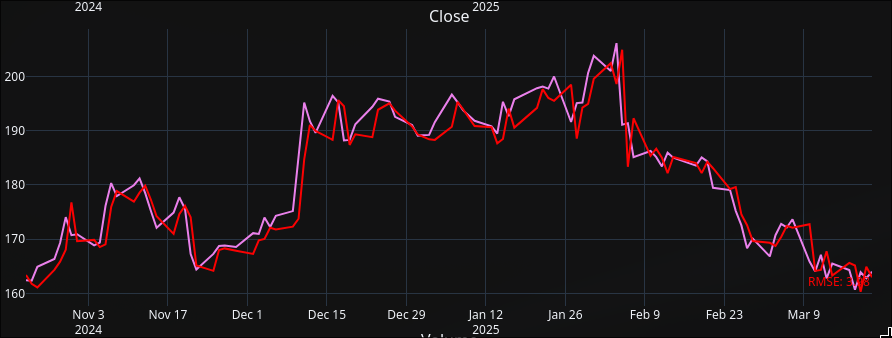

The predictions of the model are good, because each prediction is only 1 time step into the future. This does not mean that the model will be good at making longer predictions, especially with this kind of data.

In [60]:
# Predicting
predictions = model.predict(X_test, verbose=False)
predictions = rnn_formater.scaler.inverse_transform(predictions)

# Showing predictions and data
index_1 = y_test.shape[0]
df_y_test = df[columns].iloc[-index_1:]
df_predictions = pd.DataFrame(predictions, index=df_y_test.index, columns=[f'pred_{col}' for col in columns])
df_test_pred = pd.concat([df_y_test, df_predictions], axis=1)

In [61]:
def plot_predictions(y_values_df, predictions_df, title_add=''):
    """
    Plots actual values and predictions for each feature in separate subplots.
    
    Args:
        y_values_df (pd.DataFrame): DataFrame containing actual values.
        predictions_df (pd.DataFrame): DataFrame containing predicted values.
        title_add (str, optional): Additional title for the subplots.
    """
    # Number/color per features 
    columns = [col for col in y_values_df.columns]
    num_features = len(columns)
    actual_colors = ['cyan', 'lime', 'yellow', 'violet', 'gold', 'pink']

    # Creating subplots
    fig = make_subplots(rows=num_features, cols=1, vertical_spacing=0.03, subplot_titles=[col.title() for col in columns])

    for i, col in enumerate(columns):
        # Actual values trace
        fig.add_trace(go.Scatter(x=y_values_df.index, y=y_values_df[col], mode='lines', name=col.title(),
                                 line=dict(color=actual_colors[i % len(actual_colors)])), row=i+1, col=1)
        
        # Predicted values trace
        pred_col = f'pred_{col}'
        if pred_col in predictions_df.columns:
            fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df[pred_col], 
                                     mode='lines', name=f'Predicted {col.title()}', line=dict(color='red')), row=i+1, col=1)
            
            # Calculate RMSE and add as an annotation
            rmse = np.sqrt(np.mean((y_values_df[col] - predictions_df[pred_col]) ** 2))
            fig.add_annotation(xref='x domain', yref='y domain', x=1, y=0.05, showarrow=False,
                               text=f'RMSE: {rmse:.2f}', row=i+1, col=1, font=dict(color='red'))
    fig.update_layout(height=350*num_features, width=1100, title_text="Data & Predictions " + title_add)
    fig.show()


In [62]:
plot_predictions(df_y_test, df_predictions, title_add=f'- {SYMBOL} Vanilla LSTM')

## Question 9: Describe the plot below:

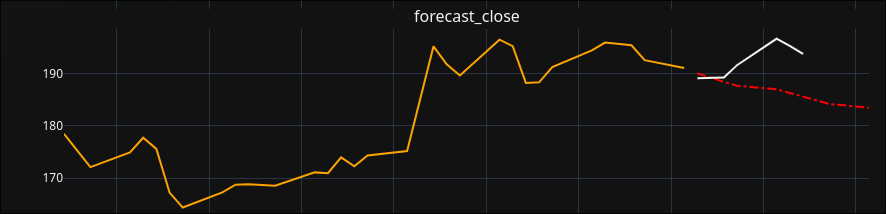

This plot shows the forecast of the closing price 10 time steps into the future. This shows how the errors of each prediction sum up when predicting more than 1 day into the future.

- In white - the actual closing price
- In red - predicted closing price

In [63]:
# Plotting function
def plot_stock_data(df, previous_data=None, test_data=None, title_add=''):
    colors = ['blue', 'green', 'purple', 'orange', 'cyan']

    fig = make_subplots(rows=df.shape[1], cols=1, shared_xaxes=True, vertical_spacing=0.02,
                        subplot_titles=df.columns)

    for i, col in enumerate(df.columns):
        fig.add_trace(
            go.Scatter(x=df.index, y=df[col], mode='lines', name=col, line=dict(dash='dashdot', color='red'),
                      ), row=i+1, col=1)

        if previous_data is not None:
            column = list(previous_data.columns)[i]
            fig.add_trace(go.Scatter(x=previous_data.index, y=previous_data[column], mode='lines', name=column,
                                     line=dict(color=colors[i % len(colors)])), row=i+1, col=1)

        if test_data is not None:
            column = list(test_data.columns)[i]
            fig.add_trace(
                go.Scatter(x=test_data.index, y=test_data[column], mode='lines', name=f'Unseen {col.title()}',
                           line=dict(color='floralwhite')), row=i+1, col=1)
            

    fig.update_layout(height=1200, width=1100, title_text=f"Stock Data Over Time {title_add}")
    fig.show()

In [64]:
# Getting last steps for LSTM forecast
last_steps = df[columns].iloc[-mapping_steps:, :]

# Number of steps to forecast
n_forecast_steps = 10 # ~ 2 weeks in business days

# Forming date index
date_index = pd.date_range(start=end_date, periods=n_forecast_steps, freq=BDay())

# Forecasting n-steps
forecast_array = rnn_formater.forecast_n_steps(model, last_steps, n_forecast_steps)
forecast = pd.DataFrame(forecast_array, index=date_index, columns=[f'forecast_{col}' for col in columns])

In [65]:
# Actual stock values to test forecast
df_test = ticker.history(start=end_date, end='2025-01-10').iloc[-n_forecast_steps:, :]
df_test.columns = df_test.columns.str.lower()

# Plotting forecast
plot_stock_data(forecast, last_steps, df_test, title_add=f'- {SYMBOL} Vanilla LSTM')

# <div style="text-align:center"> Part 5: Multi-Step Stacked LSTM model building
---

In [66]:
class RNNFormaterMultiStep:
    def __init__(self, data: pd.DataFrame, n_steps_in, n_steps_out):
        """
        Initialize the RNNFormater with a DataFrame, number of input steps, and number of output steps.
        
        Args:
            data (pd.DataFrame): Input DataFrame containing time series data.
            n_steps_in (int): Number of time steps for each input sequence.
            n_steps_out (int): Number of time steps for each output sequence.
        """
        self.df = data.copy()
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out
        self.n_columns = self.df.shape[1]
        
        self.scaler = MinMaxScaler()
        self.normalized_data = self.scaler.fit_transform(self.df.values)

    def data_mapping(self):
        """
        Maps a 2D array into a 3D array for RNN input, with each sequence having n_steps_in time steps
        and each target having n_steps_out time steps.
        
        Returns:
            X (np.array): A 3D array of input sequences.
            y (np.array): A 3D array of target sequences.
        """
        num_samples = len(self.normalized_data) - self.n_steps_in - self.n_steps_out + 1

        X = np.empty((num_samples, self.n_steps_in, self.n_columns))
        y = np.empty((num_samples, self.n_steps_out, self.n_columns))

        for i in range(num_samples):
            X[i, :, :] = self.normalized_data[i:i + self.n_steps_in, :]
            y[i, :, :] = self.normalized_data[i + self.n_steps_in:i + self.n_steps_in + self.n_steps_out, :]

        return X, y

    def rnn_train_test_split(self, X, y, test_percent=0.1):
        """
        Splits the 3D mapped data into training and testing sets for an RNN.
        
        Args:
            X (np.array): The input data sequences.
            y (np.array): The target data sequences.
            test_percent (float): The fraction of data to be used for testing.
        
        Returns:
            X_train, X_test, y_train, y_test (tuple): Split data into training and testing sets.
        """
        test_size = int(len(X) * test_percent)
        X_train, y_train = X[:-test_size], y[:-test_size]
        X_test, y_test = X[-test_size:], y[-test_size:]

        return X_train, X_test, y_train, y_test

    def multi_step_forecast(self, model, data: np.array):
        """
        Forecast multiple steps ahead using the LSTM model.
        
        Args:
            model (tf.keras.Model): Trained LSTM model for prediction.
            data (pd.DataFrame): Input DataFrame containing the latest time series data.
        
        Returns:
            pd.DataFrame: Forecasted values for n_steps_out steps.
        """    
        # Normalizing latest data
        last_steps_normalized = self.scaler.transform(data)
        last_steps_normalized = last_steps_normalized.reshape(1, self.n_steps_in, self.n_columns)
        
        # Predicting using model
        forecast = model.predict(last_steps_normalized)
        forecast = forecast.reshape(self.n_steps_out, self.n_columns)

        # Inverse transforming to original scale
        forecast = self.scaler.inverse_transform(forecast)
        forecast = pd.DataFrame(forecast, columns=[f'forecast_{col}' for col in self.df.columns])
        
        return forecast
        

## Question 10: What is the difference between data_mapping, rnn_train_test_split and multi_step_forecast from this model and the previous one in part 3?

The single step LSTM network that I trained before could still predict multiple steps ahead, but it was trained and evaluated on predictions for only 1 step into the future. The multi-step LSTM, that these functions pre-process the data for, is going to be explicitly trained to predict a sequence. 

To do this, the data pre-processing needs to be done a little differently. Where we used to have just 1 target value, now is a whole array of target values, so the model can be properly evaluated on a whole sequence of outputs.

In [94]:
n_steps_in = 252  # ~ 1 year in business days mapping
n_steps_out = 21  # ~ 1 month forecast in business days

# Intializing created RNN class
ms_rnn_formatter = RNNFormaterMultiStep(df[columns], n_steps_in, n_steps_out)

# Normalizing and data mappings for input & output
X, y = ms_rnn_formatter.data_mapping()

# Train Test split
X_train, X_test, y_train, y_test = ms_rnn_formatter.rnn_train_test_split(X, y)

print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}') # (time mapes, time steps, columns)
print(f'\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

X_train shape: (1566, 252, 5)
y_train shape: (1566, 21, 5)

X_test shape: (173, 252, 5)
y_test shape: (173, 21, 5)


In [95]:
# For consistant results
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Multi-Step LSTM
ms_model = models.Sequential([
    
    # Layer 1
    LSTM(units=40, return_sequences=True, input_shape=(n_steps_in, len(columns)), kernel_initializer='orthogonal'),

    # Layer 2
    LSTM(units=20, return_sequences=False),
    # Bidirectional(LSTM(units=20, return_sequences=False)),

    # Output layer
    Dense(units=n_steps_out * len(columns))   
])

ms_model.compile(optimizer='adam', loss='mse')

ms_history = ms_model.fit(X_train, y_train.reshape(-1, n_steps_out * len(columns)), 
                          batch_size=1024,
                          epochs=150, 
                          validation_data=(X_test, y_test.reshape(-1, n_steps_out * len(columns))), 
                          shuffle=False, 
                          verbose=False)

/home/atvars/miniconda3/envs/AAI4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



## Question 11: Discuss the following plot:

In [96]:
px.line(ms_history.history,
                      title='Stacked Multi-Step LSTM Model Loss')

In [97]:
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print()
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_test shape: (173, 252, 5)
y_test shape: (173, 21, 5)

X_train shape: (1566, 252, 5)
y_train shape: (1566, 21, 5)


From the plot, I can tell that the model is overfitting in the beginning, but after some time, the validation loss approaches the training loss, meaning that the model has stopped overfitting.

In [98]:
def plot_forecast(previous_data, forecast, test_data=None, title_add=''):
    """
    Plots actual values and predictions for each feature in separate subplots.
    
    Args:
        previous_data (pd.DataFrame): DataFrame containing actual values.
        forecast (pd.DataFrame): DataFrame containing predicted values.
        title_add (str, optional): Additional title for the subplots.
    """
    # Number/color per features 
    columns = [col for col in previous_data.columns]
    num_features = len(columns)
    actual_colors = ['cyan', 'gold', 'violet', 'lime', 'blue', 'pink', 'yellow']

    # Creating subplots
    fig = make_subplots(rows=num_features, cols=1, vertical_spacing=0.03, subplot_titles=[col.title() for col in columns])

    for i, col in enumerate(columns):
        # Actual values trace
        fig.add_trace(
            go.Scatter(x=previous_data.index, y=previous_data[col], mode='lines', name=col.title(),
                       line=dict(color=actual_colors[i % len(actual_colors)])), row=i+1, col=1)
        
        # Predicted values trace
        pred_col = f'forecast_{col}'
        if pred_col in forecast.columns:
            fig.add_trace(
                go.Scatter(x=forecast.index, y=forecast[pred_col], 
                           mode='lines', name=f'Forecast {col.title()}', line=dict(color='red')), row=i+1, col=1)

        if test_data is not None:
            fig.add_trace(
                go.Scatter(x=test_data.index, y=test_data[col], mode='lines', name=f'Unseen {col.title()}',
                           line=dict(color='floralwhite')), row=i+1, col=1)
            
            
    fig.update_layout(height=350*num_features, width=1100, title_text="Data and Forecast " + title_add)
    fig.show()

In [99]:
# Getting stock data for forecasting
data_to_test = df[columns].iloc[-n_steps_in:]

# Showing data
print(f'Test Data Shape: {data_to_test.shape}')
# Forecasting using rnn
forecast = ms_rnn_formatter.multi_step_forecast(ms_model, data_to_test.values)

# Setting index as datetime corresponding to forecast period
forecast.index = pd.date_range(start=end_date, periods=n_steps_out, freq=BDay())
print(f'Forecast shape: {forecast.shape}')

Test Data Shape: (252, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Forecast shape: (21, 5)


In [107]:
df_test = ticker.history(start=end_date, end='2025-02-01').iloc[-n_steps_out:, :]
df_test.columns = df_test.columns.str.lower()


# Plotting stacked mutli-step LSTM forecast
plot_forecast(data_to_test[columns], forecast, df_test, title_add=f'- GOOGL Stock')

## Question 12: Why do you think that the model is bad? Try to find a better forecast. Think about a possible solution.

If I look at the plot of the volume predictions, the model really isn't that far off of the actual values. This makes me think that the model hasn't taken into account the trend of the data. The stock price of Google keeps increasing, but the model has been trained on financial data from 2017, but the closing price of the stocks has grown significantly since then.

Since we created the validation set by just splitting it off at one point from the training set, this means that the model was trained on only older data.

So, to fix the issue, I would first find the trend in the data, then remove it from the training and test data, then train the model, then introduce the trend back in after I've made predictions of the data. 

Another possible fix would be to split the validation set using walk-forward validation.

The third potential improvement would be to scale the data with a scaler that is fitted on a sliding window as well. Right now, the scaler is fitted on the whole dataset, which scales data, but still keeps the trend. 

## Question 13: What is the difference between the Multi-Step Stacked LSTM model from this exercise and the sequence-to-sequence model seen in the theory? Which one do you think will perform better? 

The sequence-to-sequence models (at least the more powerful ones) contain an attention mechanism that allows the model to "remember" longer term patterns. These models can also be used with input data that has a varying length, meaning that I wouldn't need to create a fixed sliding window for training it, or making predictions.

I think that a sequence-to-sequence model will give better results, because the model wouldn't be restriced to find patterns in only 30 days, or any amount that I define, and it would take into account older patterns in the data as well.